<a href="https://colab.research.google.com/github/passive-radio/horse_race_pred/blob/main/horce_race_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pandas
!pip install -q lightgbm
!pip install -q optuna
!pip install -q sklearn
!pip install -q japanize_matplotlib
!pip install tqdm

     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 210 kB 55.6 MB/s 
     |████████████████████████████████| 80 kB 8.2 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 112 kB 68.5 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 149 kB 44.5 MB/s 
     |████████████████████████████████| 4.1 MB 4.2 MB/s 


In [ ]:
import pandas as pd
import lightgbm as lgb
import optuna.integration.lightgbm as oplgb
import optuna

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [ ]:
basepath = "drive/MyDrive/Colab_sources/horce_race_pred/data/"
endpath = "train_df_2020_2022_v2.csv"


train_df = pd.read_csv(basepath+endpath, sep=",")

train_df2 = train_df.drop(columns=["time"])
train_df2 = train_df2.fillna({'last_pos': 0.5, 'average_pos': 0.5,
                "other_pos_1": 0.5, "other_pos_2": 0.5, "other_pos_3": 0.5,
                'last_speed': train_df2["last_speed"].mean(),
                'average_speed': train_df2["average_speed"].mean(),
                "other_speed_1": train_df2["other_speed_1"].mean(),
                "other_speed_2": train_df2["other_speed_2"].mean(),
                "other_speed_3": train_df2["other_speed_3"].mean()})

had_nan = 0
for i, parm in enumerate(train_df2.isnull().sum()):
    if parm != 0:
        print(f'contains nan at {train_df2.columns[i]}')
        had_nan += 1
if had_nan > 0:
    had_nan = True
else:
    had_nan = False
print(f"had nan: {had_nan}")

print(train_df2.columns)

contains nan at race_date
had nan: True
Index(['Unnamed: 0', 'level_0', 'level_1', 'rank', 'horse_num', 'horse_name',
       'weight_j', 'jockey', 'odds', 'weight_h', 'trainer', 'race_id',
       'weight_h_shift', 'type', 'direction', 'length', 'weather',
       'start_time', 'horse_total', 'isin3rd', 'race_date', 'age', 'sex',
       'region', 'last_pos', 'last_speed', 'average_pos', 'average_speed',
       'other_pos_1', 'other_pos_2', 'other_speed_1', 'other_speed_2',
       'other_pos_3', 'other_speed_3'],
      dtype='object')


In [ ]:
train_df2["start_time"] = train_df2["start_time"].astype(int)

In [ ]:
train_df3 = train_df2.drop(columns=["rank","race_id", "odds", "race_date", "level_0", "level_1", "Unnamed: 0"])

race_id_unique = list(train_df2["race_id"].unique())
train_index, test_index = train_test_split(race_id_unique, train_size=0.66, random_state=1024)

train = train_df3[train_df2["race_id"].isin(train_index)]
test = train_df3[train_df2["race_id"].isin(test_index)]
train_with_rank = train_df2[train_df2["race_id"].isin(train_index)]
test_with_rank = train_df2[train_df2["race_id"].isin(test_index)]

categories_horse_name = train['horse_name'].unique()
categories_jockey_name = train['jockey'].unique()
categories_trainer_name = train["trainer"].unique()
categories_type = train["type"].unique()
categories_direction = train["direction"].unique()
categories_weather = train["weather"].unique()
cat_sex = train["sex"].unique()
cat_region = train["region"].unique()


category_dict = {"horse_name": categories_horse_name, "jockey": categories_jockey_name, "trainer": categories_trainer_name,
    "direction": categories_direction, "type": categories_type, "weather": categories_weather, "sex": cat_sex, "region": cat_region}

for key, value in category_dict.items():
    train[key] = pd.Categorical(train[key], categories=value)
    test[key] = pd.Categorical(test[key], categories=value)
    
df_train = pd.get_dummies(train, columns=["horse_name", "jockey", "trainer", "type", "direction", "weather", "sex", "region"])
df_test = pd.get_dummies(test, columns=["horse_name", "jockey", "trainer", "type", "direction", "weather", "sex", "region"])

X_train = df_train.drop(["isin3rd"], axis=1)
y_train = df_train["isin3rd"]

X_test = df_test.drop(["isin3rd"],axis=1)
y_test = df_test["isin3rd"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_col_list = []
test_col_list = []
for i in range(len(X_train.columns)):
    train_col_list.append(X_train.columns[i])
for i in range(len(X_test.columns)):
    test_col_list.append(X_test.columns[i])
#lgbmで要素数不一致により実行がエラーとなるのを事前に確かめる(時間がかかるので)
print(set(train_col_list) ^ set(test_col_list))
    

set()


In [ ]:
def rank_to_rank1(value):
        if value == 1.0:
            return 1
        else:
            return 0

def cal_return(col):
        if col["rank1"] == 1:
            return col["odds"] - 1.0
        else:
            return -1

In [ ]:
# studyの際に、最大化する数値をreturnする関数　※１
def objective(trial):
    params = {
        'objective': 'binary',
        'feature_pre_filter': False,
        'metric': "binary_logloss",
        "verbose": -1,
        "num_iterations": trial.suggest_int('num_iterations', 10, 1000), 
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 1.0)
    }
    
    gbm = lgb.train(params=params, train_set=lgb_train,valid_sets=[lgb_train, lgb_eval], num_boost_round=100, verbose_eval=False, early_stopping_rounds=10)
    oof = (gbm.predict(X_test) > 0.5).astype(int)
    recall_scoree = recall_score(y_test, oof)
    precision_scoree = precision_score(y_test, oof)
    accuracy = accuracy_score(y_test, oof)
    return accuracy

In [ ]:
# studyの際に、最大化する数値をreturnする関数　※１
def objective_v2(trial):
    params = {
        'objective': 'binary',
        'feature_pre_filter': False,
        'metric': "binary_logloss",
        "verbose": -1,
        "num_iterations": trial.suggest_int('num_iterations', 10, 1000), 
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 1.0)
    }
    
    gbm = lgb.train(params=params, train_set=lgb_train,valid_sets=[lgb_train, lgb_eval], num_boost_round=100, verbose_eval=False, early_stopping_rounds=10)
    test_with_rank["predict"] = gbm.predict(X_test)

    test_with_rank2 = test_with_rank.copy()
    df_temp2 = pd.DataFrame()
    for race_id in test_index:
        df_temp = test_with_rank2[test_with_rank2.race_id == race_id].copy()
        no1 = df_temp["predict"].idxmax()
        no2 = df_temp.drop(index = no1)["predict"].idxmax()
        no3 = df_temp.drop(index = [no1, no2])["predict"].idxmax()
        rank_place = [no1, no2, no3]
        
        for i, rank_place in enumerate(rank_place):
            df_temp2.loc[rank_place, "rank_pred"] =i+1
            df_temp2.loc[rank_place, "isin3rd_pred"] = 1
    test_with_rank2 = pd.concat([test_with_rank2, df_temp2], axis="columns")
    test_with_rank2.fillna({"isin3rd_pred": 0}, inplace=True)

    # test_with_rank2["rank1"] = test_with_rank2["rank"].apply(rank_to_rank1)
    # test_with_rank2["rank1_pred"] = test_with_rank2["rank_pred"].apply(rank_to_rank1)

    oof2 = test_with_rank2["isin3rd_pred"]
    y_test2 = test_with_rank2["isin3rd"]
    recall_scoree = recall_score(y_test2, oof2)
    precision_scoree = precision_score(y_test2, oof2)

    # isin3rd_pred_df = test_with_rank2[test_with_rank2["isin3rd_pred"] == 1]
    # isin3rd_pred_df["return_isin3rd"] = isin3rd_pred_df.apply(lambda x:cal_return(x), axis=1)

    # rank1_pred_df = test_with_rank2[test_with_rank2["rank1_pred"] == 1]
    # rank1_pred_df["return_no1"] = rank1_pred_df.apply(lambda x:cal_return(x), axis=1)

    # return1 = isin3rd_pred_df["return_isin3rd"].sum()/len(isin3rd_pred_df)
    f05 = 1.25*precision_scoree*recall_scoree/(0.25*precision_scoree+recall_scoree)
    return f05

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)

# optunaのstudyを実施。accuracyの方向をmaximizeする。
study = optuna.create_study(direction='maximize')
study.optimize(objective_v2, timeout=60*120)

# 上のstudyで得られた最高のパラメータを取り出す
best_params = study.best_trial.params

# 上のstudyで得られた最高のパラメータには、
# 単一選択肢だったものは保存されないので、
# 消えてしまったobjectiveを加える
best_params["objective_"]="binary"
best_params['feature_pre_filter'] = False
best_params['metric'] = 'binary_logloss'

[I 2022-02-01 17:31:34,401] A new study created in memory with name: no-name-9ddbcead-3f2b-4183-8ffb-dcc665be4787
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[I 2022-02-01 17:32:36,941] Trial 0 finished with value: 0.4512689798826947 and parameters: {'num_iterations': 794, 'lambda_l1': 0.08546093566226277, 'lambda_l2': 0.0006678687647360933, 'num_leaves': 93, 'feature_fraction': 0.18840522643568014, 'bagging_fraction': 0.9664609237919186, 'bagging_freq': 5, 

In [13]:
#Optunaハイパラメータチューニングのベストパラペータで再学習
evals_result = {}
gbm = lgb.train(params=best_params, train_set=lgb_train, valid_sets=[lgb_train, lgb_eval],
                num_boost_round = 100, early_stopping_rounds=10, evals_result=evals_result, verbose_eval=False)


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [14]:
best_params

{'bagging_fraction': 0.7322644587889409,
 'bagging_freq': 3,
 'feature_fraction': 0.09371600212005901,
 'feature_pre_filter': False,
 'lambda_l1': 0.011549245776195843,
 'lambda_l2': 1.2868178648014473e-07,
 'learning_rate': 0.007928835740231911,
 'metric': 'binary_logloss',
 'min_child_samples': 14,
 'num_iterations': 619,
 'num_leaves': 466,
 'objective_': 'binary'}

recall score:  0.0004108463434675431
precision score:  0.75
accuracy score:  78.23


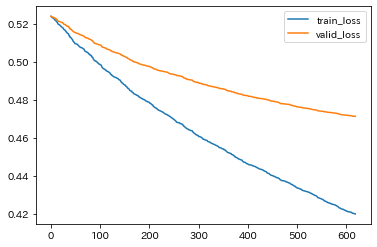

In [15]:
oof = (gbm.predict(X_test) > 0.6).astype(int)

y_pred = gbm.predict(X_test)
recall_scoree = recall_score(y_test, oof)
precision_scoree = precision_score(y_test, oof)

plt.plot(evals_result["training"]["binary_logloss"], label="train_loss")
plt.plot(evals_result["valid_1"]["binary_logloss"], label="valid_loss")
plt.legend()

print("recall score: ", recall_scoree) #再現率: 実際に正であるもののうち，正であると予測されたものの割合
print("precision score: ", precision_scoree) #適合率: 正と予測したデータのうち，実際に正であるものの割合.「精度」と呼ぶこともあり
print("accuracy score: ", round(accuracy_score(y_test, oof)*100, 2)) #正解率: 全データに対するy=0,1の正答率


In [16]:
importance_df = pd.DataFrame({"特徴": X_train.columns, "importance": gbm.feature_importance()}).sort_values("importance", ascending=False)
importance_df.head(16)

,特徴,importance
17,other_speed_3,16602
15,other_speed_2,16261
11,average_speed,13126
9,last_speed,12432
14,other_speed_1,12023
2,weight_h,10803
10,average_pos,10019
3,weight_h_shift,9160
0,horse_num,8983
12,other_pos_1,8513


In [17]:
test_with_rank["predict"] = gbm.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
test_with_rank2 = test_with_rank.copy()
df_temp2 = pd.DataFrame()
for race_id in tqdm(test_index):
    rank_place = []
    df_temp = test_with_rank2[test_with_rank2.race_id == race_id].copy()
    no1 = df_temp["predict"].idxmax()
    no2 = df_temp.drop(index = no1)["predict"].idxmax()
    no3 = df_temp.drop(index = [no1, no2])["predict"].idxmax()

    if df_temp.loc[no1, "predict"] > 0.55:
        rank_place.append(no1)
    if df_temp.loc[no2, "predict"] > 0.52:
        rank_place.append(no2)
    if df_temp.loc[no3, "predict"] > 0.5:
        rank_place.append(no3)
    
    for i, rank_place in enumerate(rank_place):
        df_temp2.loc[rank_place, "rank_pred"] =i+1
        df_temp2.loc[rank_place, "isin3rd_pred"] = 1
test_with_rank2 = pd.concat([test_with_rank2, df_temp2], axis="columns")
test_with_rank2.fillna({"isin3rd_pred": 0}, inplace=True)
test_with_rank2[["rank", "odds", "rank_pred", "isin3rd_pred"]].head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/2432 [00:00<?, ?it/s]

,rank,odds,rank_pred,isin3rd_pred
43,1.0,5.4,NaN,0.0
44,2.0,2.4,NaN,0.0
45,3.0,15.4,NaN,0.0
46,4.0,30.3,NaN,0.0
47,5.0,4.3,NaN,0.0
48,6.0,159.5,NaN,0.0
49,7.0,255.2,NaN,0.0
50,8.0,13.9,NaN,0.0
51,9.0,19.1,NaN,0.0
52,10.0,59.6,NaN,0.0


In [19]:
def rank_to_rank1(value):
    if value == 1.0:
        return 1
    else:
        return 0

test_with_rank2["rank1"] = test_with_rank2["rank"].apply(rank_to_rank1)
test_with_rank2["rank1_pred"] = test_with_rank2["rank_pred"].apply(rank_to_rank1)

## 3着以下的中率

In [20]:
oof2 = test_with_rank2["isin3rd_pred"]
y_test2 = test_with_rank2["isin3rd"]
recall_scoree = recall_score(y_test2, oof2)
precision_scoree = precision_score(y_test2, oof2)

print("recall score: ", recall_scoree) #再現率: 実際に正であるもののうち，正であると予測されたものの割合
print("precision score: ", precision_scoree) #適合率: 正と予測したデータのうち，実際に正であるものの割合.「精度」と呼ぶこともあり
print("accuracy score: ", round(accuracy_score(y_test2, oof2)*100, 2)) #正解率: 全データに対するy=0,1の正答率

recall score:  0.0026020268419611066
precision score:  0.8636363636363636
accuracy score:  78.27


## 1着的中率

In [21]:
oof3 = test_with_rank2["rank1_pred"]
y_test3 = test_with_rank2["rank1"]
recall_scoree = recall_score(y_test3, oof3)
precision_scoree = precision_score(y_test3, oof3)

print("recall score: ", recall_scoree) #再現率: 実際に正であるもののうち，正であると予測されたものの割合
print("precision score: ", precision_scoree) #適合率: 正と予測したデータのうち，実際に正であるものの割合.「精度」と呼ぶこともあり
print("accuracy score: ", round(accuracy_score(y_test3, oof3)*100, 2)) #正解率: 全データに対するy=0,1の正答率

recall score:  0.005336617405582923
precision score:  0.6190476190476191
accuracy score:  92.75


In [22]:
def cal_return(col):
    if col["rank1"] == 1:
        return col["odds"] - 1.0
    else:
        return -1

isin3rd_pred_df = test_with_rank2[test_with_rank2["isin3rd_pred"] == 1]
isin3rd_pred_df["return_isin3rd"] = isin3rd_pred_df.apply(lambda x:cal_return(x), axis=1)

rank1_pred_df = test_with_rank2[test_with_rank2["rank1_pred"] == 1]
rank1_pred_df["return_no1"] = rank1_pred_df.apply(lambda x:cal_return(x), axis=1)

isin3rd_pred_df[["rank1", "isin3rd", "rank1_pred", "odds", "return_isin3rd"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,rank1,isin3rd,rank1_pred,odds,return_isin3rd
19963,1,1,1,1.6,0.6
26553,0,1,1,1.7,-1.0
27745,0,1,1,1.9,-1.0
31651,0,1,1,1.1,-1.0
34865,0,1,1,5.5,-1.0
42335,1,1,1,3.0,2.0
42339,0,0,0,3.9,-1.0
46417,1,1,1,1.8,0.8
54110,1,1,1,1.9,0.9
58983,1,1,1,1.5,0.5


In [23]:
print(f'isin3rd_pred_return: {isin3rd_pred_df["return_isin3rd"].sum()}/{len(isin3rd_pred_df)}')
print(f'rank1_pred_return: {rank1_pred_df["return_no1"].sum()}/{len(rank1_pred_df)}')

print("-"*40)

print(f'isin3rd_pred_profit/resource: {isin3rd_pred_df["return_isin3rd"].sum()/len(isin3rd_pred_df)}')
print(f'rank1_pred_proit/resource: {rank1_pred_df["return_no1"].sum()/len(rank1_pred_df)}')

isin3rd_pred_return: -1.2/22
rank1_pred_return: -0.20000000000000018/21
----------------------------------------
isin3rd_pred_profit/resource: -0.05454545454545454
rank1_pred_proit/resource: -0.009523809523809532


In [37]:
def func(r1,r2,r3):
    test_with_rank2 = test_with_rank.copy()
    df_temp2 = pd.DataFrame()
    df_temp2["rank_pred"] = 0
    df_temp2["isin3rd_pred"] = 0
    for race_id in test_index:
        rank_place = []
        df_temp = test_with_rank2[test_with_rank2.race_id == race_id].copy()
        no1 = df_temp["predict"].idxmax()
        no2 = df_temp.drop(index = no1)["predict"].idxmax()
        no3 = df_temp.drop(index = [no1, no2])["predict"].idxmax()

        if df_temp.loc[no1, "predict"] > r1:
            rank_place.append(no1)
        if df_temp.loc[no2, "predict"] > r2:
            rank_place.append(no2)
        if df_temp.loc[no3, "predict"] > r3:
            rank_place.append(no3)
        
        for i, rank_place in enumerate(rank_place):
            df_temp2.loc[rank_place, "rank_pred"] =i+1
            df_temp2.loc[rank_place, "isin3rd_pred"] = 1

    test_with_rank2 = pd.concat([test_with_rank2, df_temp2], axis="columns")
    test_with_rank2.fillna({"isin3rd_pred": 0}, inplace=True)

    test_with_rank2["rank1"] = test_with_rank2["rank"].apply(rank_to_rank1)
    test_with_rank2.fillna({"rank_pred": 0}, inplace=True)

    test_with_rank2["rank1_pred"] = test_with_rank2["rank_pred"].apply(rank_to_rank1)
    isin3rd_pred_df = test_with_rank2[test_with_rank2["isin3rd_pred"] == 1]
    isin3rd_pred_df["return_isin3rd"] = -1
    isin3rd_pred_df["return_isin3rd"] = isin3rd_pred_df.apply(lambda x:cal_return(x), axis=1)

    if len(isin3rd_pred_df) > 50:
        return isin3rd_pred_df["return_isin3rd"].sum()
    else:
        return 0

def func2(r1, r2, r3):
    test_with_rank2 = test_with_rank.copy()
    df_temp2 = pd.DataFrame()
    df_temp2["rank_pred"] = 0
    df_temp2["isin3rd_pred"] = 0
    for race_id in test_index:
        rank_place = []
        df_temp = test_with_rank2[test_with_rank2.race_id == race_id].copy()
        no1 = df_temp["predict"].idxmax()
        no2 = df_temp.drop(index = no1)["predict"].idxmax()
        no3 = df_temp.drop(index = [no1, no2])["predict"].idxmax()

        if df_temp.loc[no1, "predict"] > r1:
            rank_place.append(no1)
        if df_temp.loc[no2, "predict"] > r2:
            rank_place.append(no2)
        if df_temp.loc[no3, "predict"] > r3:
            rank_place.append(no3)
        
        for i, rank_place in enumerate(rank_place):
            df_temp2.loc[rank_place, "rank_pred"] =i+1
            df_temp2.loc[rank_place, "isin3rd_pred"] = 1

    test_with_rank2 = pd.concat([test_with_rank2, df_temp2], axis="columns")
    test_with_rank2.fillna({"isin3rd_pred": 0}, inplace=True)

    test_with_rank2["rank1"] = test_with_rank2["rank"].apply(rank_to_rank1)
    test_with_rank2.fillna({"rank_pred": 0}, inplace=True)

    test_with_rank2["rank1_pred"] = test_with_rank2["rank_pred"].apply(rank_to_rank1)
    isin3rd_pred_df = test_with_rank2[test_with_rank2["isin3rd_pred"] == 1]
    isin3rd_pred_df["return_isin3rd"] = -1
    isin3rd_pred_df["return_isin3rd"] = isin3rd_pred_df.apply(lambda x:cal_return(x), axis=1)
    return isin3rd_pred_df

In [38]:
def optimizer(trial):
    params = {
        'r1': trial.suggest_uniform('r1', 1e-2, 0.6),
        'r2': trial.suggest_uniform('r2', 1e-2, 1.0),
        'r3': trial.suggest_uniform('r3', 1e-2, 1.0)
    }
    return func(params["r1"], params["r1"]*params["r2"], params["r1"]*params["r3"])

In [39]:
study = optuna.create_study(direction='maximize')
# 最適化実行
study.optimize(optimizer, timeout=60*30)

[I 2022-02-02 01:17:17,572] A new study created in memory with name: no-name-c307cfa1-3222-4e5e-890a-b51c56800b81
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[I 2022-02-02 01:17:28,743] Trial 0 finished with value: -1726.1 and parameters: {'r1': 0.02278943733354985, 'r2': 0.42504088429960446, 'r3': 0.7687658531723619}. Best is trial 0 w

In [ ]:
isin3rd_pred_df[["rank1", "isin3rd", "rank1_pred", "odds", "return_isin3rd"]]

NameError: ignored

In [63]:
params_r = {'r1': 0.5429029299335244, 'r2': 0.9331143678333051, 'r3': 0.7299737864126938}

test_with_rank2 = test_with_rank.copy()
df_temp2 = pd.DataFrame()
df_temp2["rank_pred"] = 0
df_temp2["isin3rd_pred"] = 0
for race_id in test_index:
    rank_place = []
    df_temp = test_with_rank2[test_with_rank2.race_id == race_id].copy()
    no1 = df_temp["predict"].idxmax()
    no2 = df_temp.drop(index = no1)["predict"].idxmax()
    no3 = df_temp.drop(index = [no1, no2])["predict"].idxmax()

    if df_temp.loc[no1, "predict"] > params_r["r1"]:
        rank_place.append(no1)
    if df_temp.loc[no2, "predict"] > params_r["r1"]*params_r["r2"]:
        rank_place.append(no2)
    if df_temp.loc[no3, "predict"] > params_r["r1"]*params_r["r3"]:
        rank_place.append(no3)
    
    for i, rank_place in enumerate(rank_place):
        df_temp2.loc[rank_place, "rank_pred"] =i+1
        df_temp2.loc[rank_place, "isin3rd_pred"] = 1

test_with_rank2 = pd.concat([test_with_rank2, df_temp2], axis="columns")
test_with_rank2.fillna({"isin3rd_pred": 0}, inplace=True)

test_with_rank2["rank1"] = test_with_rank2["rank"].apply(rank_to_rank1)
test_with_rank2.fillna({"rank_pred": 0}, inplace=True)

test_with_rank2["rank1_pred"] = test_with_rank2["rank_pred"].apply(rank_to_rank1)
isin3rd_pred_df = test_with_rank2[test_with_rank2["isin3rd_pred"] == 1]
isin3rd_pred_df["return_isin3rd"] = -1

def cal_return(col):
    if col["rank1"] == 1:
        return col["odds"] - 1.0
    else:
        return -1

def cal_resource(col):
    return 1

def cal_return2(col):
    if col["rank1"] == 1:
        return (col["odds"] - 1.0)*col["predict"]/0.1
    else:
        return -1*col["predict"]/0.1

def cal_resource2(col):
    return col["predict"]/0.1

isin3rd_pred_df["return_isin3rd_1"] = isin3rd_pred_df.apply(lambda x:cal_return(x), axis=1)
isin3rd_pred_df["resource_1"] = isin3rd_pred_df.apply(lambda x:cal_resource(x), axis=1)

isin3rd_pred_df["return_isin3rd_2"] = isin3rd_pred_df.apply(lambda x:cal_return2(x), axis=1)
isin3rd_pred_df["resource_2"] = isin3rd_pred_df.apply(lambda x:cal_resource2(x), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [64]:
print(f'isin3rd_pred_return: {isin3rd_pred_df["return_isin3rd_1"].sum()}/{isin3rd_pred_df["resource_1"].sum()}')
print(f'isin3rd_pred_profit/resource: {isin3rd_pred_df["return_isin3rd_1"].sum()/isin3rd_pred_df["resource_1"].sum()}')

print("-"*30)

print(f'isin3rd_pred_return: {isin3rd_pred_df["return_isin3rd_2"].sum()}/{isin3rd_pred_df["resource_2"].sum()}')
print(f'isin3rd_pred_profit/resource: {isin3rd_pred_df["return_isin3rd_2"].sum()/isin3rd_pred_df["resource_2"].sum()}')

isin3rd_pred_return: 12.099999999999998/60
isin3rd_pred_profit/resource: 0.20166666666666663
------------------------------
isin3rd_pred_return: 55.070727749814004/291.29743923522346
isin3rd_pred_profit/resource: 0.1890532505002361


In [50]:
isin3rd_pred_df["predict"]

15000    0.416735
16101    0.543319
19963    0.570327
19971    0.401693
24424    0.405915
26500    0.399144
26553    0.562927
27000    0.437874
27745    0.624461
29385    0.400871
31651    0.607217
31793    0.399545
34086    0.401274
34864    0.441227
34865    0.559321
37385    0.441665
39102    0.400326
42335    0.575281
42337    0.488190
42339    0.575141
43124    0.410624
44959    0.398333
45677    0.421108
46417    0.556137
49950    0.401743
54110    0.682273
54177    0.545289
56104    0.418590
58983    0.597696
61618    0.436411
65196    0.405192
65338    0.580579
65352    0.552790
68934    0.444152
71429    0.402700
72569    0.419189
72771    0.653978
73620    0.557317
73802    0.400882
75205    0.403318
76927    0.402179
78876    0.421048
79492    0.563844
81016    0.558798
81367    0.548342
81495    0.594855
81585    0.414090
82947    0.414977
83749    0.397678
83987    0.436877
84203    0.427469
87310    0.524800
90198    0.563281
90793    0.427570
91412    0.429972
93039    0